# 학습 목표
3장에서 배운 인공 신경망을 이용하여 Fashion MNSIT 데이터셋 안의 패션 아이템을 구분해보자! -> 데이터셋 다루는 법, 성능 측정법, 과적합, 정규화 등 머신러닝의 핵심 개념을 익힌다.

# 목차
- Fashion MNIST 데이터셋 알아보기
- 인공 신경망으로 패션 아이템 분류하기
- 성능 측정하기
- 과적합과 드롭아웃

### 1. Fashion MNIST 데이터셋 알아보기

In [1]:
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

- **torch.utils.data** : 데이터셋의 표준을 정의하고, 데이터셋을 불러오고 자르고 섞는데 쓰는 도구들이 들어있는 모듈. 파이토치 모델을 학습시키기 위한 데이터셋의 표준을 torch.utils.data.**Dataset**에 정의한다. Dataset 모듈을 상속한 클래스는 torch.utils.data.**DataLoader**(학습에 필요한 데이터 로딩해준다)을 입력하여 사용할 수 있다.

> 표준데이터 : 정보시스템에서 사용되는 용어 및 도메인, 코드, 기타 데이터 관련 요소에 대해 공통된 형식과 내용으로 정의하여 사용하는 표준 관련 데이터.

- **torchvision.datasets** : torch.utils.data.Dataset을 상속하는 **이미지 데이터셋**의 모음.

- **torchvision.transforms** : 이미지 데이터셋에 쓸 수 있는 여러 가지 변환 필터를 담고 있는 모듈. ex) 크기 조절, 텐서로 변환, 크롭, 밝기 및 대비 조절 등

- **torchvision.utils** : 이미지 데이터를 저장하고 시각화하기 위한 도구가 들어있는 모듈

In [2]:
# 이미지를 텐서로 바꿔주는 코드
transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Resize() 이미지 크기 조정
    # transforms.Normalize() 정규화
    # transforms.RandomHorizontalFlip 무작위로 이미지 오른쪽과 왼쪽 뒤집기
    # transforms.RandomCrop 이미지를 무작위로 자르는 기능
])

In [3]:
# 데이터셋 가져오기
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True, # train 데이터셋을 받을 것인지
    download = True,
    transform = transform # Compose로 만들어 둔 이미지 변환 실행
)

testset = datasets.FashionMNIST(
    root = './.data/',
    train = False, # test 데이터셋을 받을 것인지 선택
    download = True,
    transform = transform
)

In [4]:
# 배치 크기(batch size) : 한 번에 처리하는 데이터 개수
batch_size = 16

# 앞에서 Dataset을 상속받은 애들은
# DataLoader 를 통해 학습에 필요한 데이터 로딩해준다
train_loader = data.DataLoader(  
    dataset = trainset,
    batch_size = batch_size
)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size
)

In [5]:
# 배치 하나(현재 배치 하나: 16개)를 뽑아 데이터가 어떻게 생겼는지 확인하기
dataiter = iter(train_loader)
images, labels = next(dataiter)

> 💡 참고 링크: [iter, next](https://dojang.io/mod/page/view.php?id=2408)

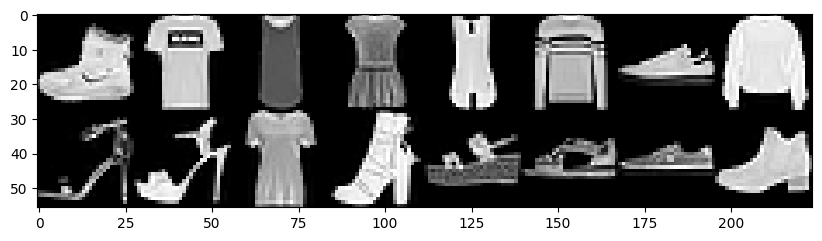

In [6]:
img = utils.make_grid(images, padding = 0) # make_grid 로 여러 이미지를 하나의 이미지로 만들기
npimg = img.numpy() # 현재 img는 텐서이기 떄문에 matplotlib과 호환되는 numpy 행렬로 바꿔준다
plt.figure(figsize = (10, 7))
plt.imshow(np.transpose(npimg, (1, 2, 0))) # matplotlib이 인식하는 차원 순서 다르기 때문에 바꿔줘야함
plt.show()

In [7]:
print(labels)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


데이터셋에서는 패션 아이템 분류를 숫자로 하고 있기 때문에 해석하기 편하도록 클래스 딕셔너리 생성.

In [8]:
CLASSES = {
    0: 'T-shirt/top', # 티셔츠/윗옷
    1: 'Trouser',     # 바지
    2: 'Pullover',    # 스웨터
    3: 'Dress',       # 드레스
    4: 'Coat',        # 코트
    5: 'Sandal',      # 샌들
    6: 'Shirt',       # 셔츠
    7: 'Sneaker',     # 운동화
    8: 'Bag',         # 가방
    9: 'Ankle boot'   # 앵클부츠
}

In [9]:
for label in labels:
    idx = label.item()
    print(CLASSES[idx])

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot


이미지 데이터는 `(가로, 세로, 색상)`으로 구성된 3차원 행렬로 표현.

현재 Fashion MNiST의 크기는 28 * 28, 색상은 흑백이므로 1의 값을 가짐.

따라서 28 * 28 * 1 = 784 개이다.

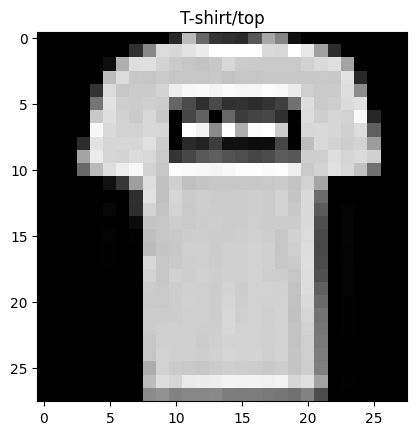

In [10]:
# 개별 이미지 꺼내 보기
idx = 1
item_img = images[idx]
item_npimg = item_img.squeeze().numpy() # matplotlib에서 이용가능한 numpy 행렬 만들기
plt.title(CLASSES[labels[idx].item()])
plt.imshow(item_npimg, cmap = 'gray')
plt.show()

### 2. 인공 신경망으로 패션 아이템 분류하기
패션 아이템 이미지를 인식하여 레이블을 예측하는 기본적인 **심층 인공 신경망(DNN)** 만들기

#### 2-1) 환경 설정하기
- `nn` : 인공 신경망 재료들을 담고 있는 모듈
- `optim` : 최적화
- `funtional` : nn 모듈의 함수 버전

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [12]:
# 현재 컴퓨터에서 CUDA 사용 가능한 지
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [13]:
EPOCHS = 30
BATCH_SIZE = 64

#### 2-2) 이미지 분류 문제
**이미지 분류** : 한 장의 이미지를 받아 이 이미지가 어느 클래스에 속하는지 알려주는 문제. 이미지 기반 검색, 추천, 광고 등에 사용된다.

#### 2-3) 이미지 분류를 위한 인공 신경망 구현
입력 x와 레이블 y를 받아 학습한 다음, 새로운 x가 왔을 때 어떤 패션 아이템인지 에측.

사용할 모델 = 레이어가 3개인 3층 인공 신경망

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 픽셀값 784개를 입력받아, 가중치를 행렬곱하고 편향을 더해 값 256개 출력.
        self.fc1 = nn.Linear(784, 256)
        # 256개 입력, 128개 출력
        self.fc2 = nn.Linear(256, 128)
        # 128개 입력, 10개 출력 => 10개는 각각의 패션 아이템의 클래스
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):# 데이터를 입력받아서
        x = x.view(-1, 784) # 요소 수가 784 개인 1차원 행렬로 만들고
        x = F.relu(self.fc1(x)) # fc1 ,2거치고 활성화 함수 relu
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x

fc : 'fully connected'의 약자로 이전 레이어의 모든 노드가 다음 레이어의 모든 노드에 연결된 층, 다른 말로 Dense 층이라고도 한다. (케라스에서 주요 사용)

모델 생성이 완료되었으니 모델을 선언해보자.

In [15]:
# 선언과 동시에 어디서 연산을 수행할지 to()로 정할 수 있음.
model= Net().to(DEVICE) # 아까 앞에서 CUDA 유무에 따라 미리 선언해뒀던 이유

# 최적화 알고리즘으로 optim.SGD 사용.
# SGD = 확률적 경사하강법
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [16]:
# 학습 = 데이터를 보고, 가중치를 조절하는 작업 반복.
def train(model, train_loader, optimizer):
    model.train() # 학습모드on
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # 앞에서 가중치를 GPU로 보냈었다면,
        # 학습 데이터도 같은 장치로 보내야 연산이 가능하다.
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        optimizer.zero_grad() # 반복 때마다 기울기를 새로 계산할 수 있도록 초기화
        output = model(data) # 모델에 넣고 돌린다.
        
        # 3장에서는 클래스가 2개라서 BCE 를 사용했는데,
        # 이번엔 10개라 교차 엔트로피 사용해야함.
        loss = F.cross_entropy(output, target)
        loss.backward() # 기울기 계산
        optimizer.step() # 가중치 수정

> 💡 참고 링크 : [BCE와 CE 차이](https://wooono.tistory.com/387)

### 3. 성능 측정하기

- **일반화** : 세상에 존재하는 모든 데이터에 최적화 하는 것.
- **일반화 오류** : 학습 데이터를 기반으로 한 모델이 학습하지 않은 데이터에 얼마나 적응하는지를 수치로 나타낸 것. -> 학습과 실제 성능의 괴리를 뜻하므로 작을수록 좋음.

이 때, 우리가 세상에 존재하는 모든 데이터를 다 모아서 확인해볼 순 없기 때문에 학습 데이터를 일부를 떼어내서 평가용 데이터셋(=테스트셋)으로 씀.

Fashion MNIST는 규모가 작아서 학습, 테스트로 나누었는데 일반적인 머신러닝은 `학습`, `검증`, `테스트` 총 3단계로 진행됨.

- 검증 : 배치 크기, 모델 설계(모델 층 종류, 크기), 학습률과 같이 사용자가 직접 지정해주는 값(=**하이퍼파라미터**)를 조절하는데 사용됨.

In [17]:
# 모델 평가하기
def evaluate(model, test_loader):
    model.eval() # 평가 모드on
    test_loss = 0 # 테스트 오차 수
    correct = 0 # 예측이 맞은 수
    
    # 평가 과정에서는 기울기 계산 안해도 됨.(반복하는 게 아니기 때문)
    with torch.no_grad():
        for data, target in test_loader: # 똑같이 DEVICE 로 보내줌.
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data) # 예측값
            
            # 평가에서는 미니배치의 평균 대신 합을 받아야함
            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target, reduction = 'sum').item()
            
            # 오차 정보 말고 모델의 정확도도 함께 보자.
            # 우리가 예측한 output 에서 최댓값을 뽑아보면 
            # '가장 큰 값, 그 값이 있는 자리인 인덱스' 두 개가 나옴.
            # 이 가장 큰 값의 인덱스와 label 값이 같은지 확인해야함.
            
            # keepdim= True : 입력된 데이터와 출력값의 차원을 갖게 해줌
            pred = output.max(1, keepdim = True)[1] # (차원 수, keepdim)
            
            # view_as() 로 예측값과 정답 순서 맞춰주고
            # ep()으로 같으면 1, 틀리면 0로 채우고
            # sum() 을 통해 맞은 갯수 구하기
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        
    test_loss /= len(test_loader.dataset) # 오차 평균 구하기
    test_accuracy = 100. * correct / len(test_loader.dataset) # 정답률 평균 구하기
    
    return test_loss, test_accuracy

> **argmax 함수** : 배열에서 가장 큰 값이 있는 인덱스를 출력하는 함수
>
> 💡 참고 링크 : [torch.max 함수 설명](https://paintycode.tistory.com/26)

In [18]:
# 실제로 테스트 데이터 넣어서 돌려보기
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print(f"[{epoch}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

[1] Test Loss: 0.5597, Accuracy: 80.35%
[2] Test Loss: 0.4927, Accuracy: 82.30%
[3] Test Loss: 0.4583, Accuracy: 83.67%
[4] Test Loss: 0.4292, Accuracy: 84.69%
[5] Test Loss: 0.4085, Accuracy: 85.44%
[6] Test Loss: 0.3937, Accuracy: 85.88%
[7] Test Loss: 0.3837, Accuracy: 86.25%
[8] Test Loss: 0.3749, Accuracy: 86.39%
[9] Test Loss: 0.3687, Accuracy: 86.72%
[10] Test Loss: 0.3650, Accuracy: 87.09%
[11] Test Loss: 0.3576, Accuracy: 87.30%
[12] Test Loss: 0.3540, Accuracy: 87.42%
[13] Test Loss: 0.3521, Accuracy: 87.60%
[14] Test Loss: 0.3451, Accuracy: 87.79%
[15] Test Loss: 0.3419, Accuracy: 87.92%
[16] Test Loss: 0.3403, Accuracy: 88.09%
[17] Test Loss: 0.3442, Accuracy: 88.00%
[18] Test Loss: 0.3411, Accuracy: 88.14%
[19] Test Loss: 0.3439, Accuracy: 88.03%
[20] Test Loss: 0.3440, Accuracy: 88.27%
[21] Test Loss: 0.3468, Accuracy: 87.97%
[22] Test Loss: 0.3455, Accuracy: 88.10%
[23] Test Loss: 0.3446, Accuracy: 88.24%
[24] Test Loss: 0.3481, Accuracy: 88.20%
[25] Test Loss: 0.3486, A

### 4. 과적합과 드롭아웃
- 일반화 : 학습 데이터와 학습하지 않은 실제 데이터에서 동시에 높은 성능을 내는 상태

과소적합, 과적합을 막기 위해서 학습 중간에 검증용 데이터셋으로 모델이 학습 데이터에만 과적합되지 않았는지 확인해야함.

검증 데이터셋에 대한 성능이 나빠지기 시작하기 직전 모델 = 가장 적합한 모델

-> **조기 종료** 해야함.

#### 4-1) 데이터 늘리기

학습 데이터를 최대한 늘리는 방법.

ex) 이미지 일부분 자르기, 돌리기, 노이즈 더하기, 색상 변경하기 등

이번엔 간단히 오른쪽과 왼쪽 뒤집는 가로 대칭이동 전략 사용.

In [19]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./.data',
                  train = True,
                  download = True,
                  transform = transforms.Compose([
                      transforms.RandomHorizontalFlip(), # 학습데이터 수평뒤집기 -> 학습데이터 양 2배 됨.
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ])),
    batch_size = BATCH_SIZE, shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./.data',
                  transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ])),
    batch_size = BATCH_SIZE, shuffle = True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./.data\MNIST\raw\train-images-idx3-ubyte.gz to ./.data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./.data\MNIST\raw\train-labels-idx1-ubyte.gz to ./.data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./.data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./.data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./.data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./.data\MNIST\raw



#### 4-2) 드롭아웃

모델에 직접 영향을 주어 과적합 해결하는 방법 중 하나로 **드롭아웃**이 있다.

**드롭 아웃** : 학습 진행 과정에서 신경망의 일부를 사용하지 않는 방법.

학교에서 아이들을 가르치는데 반 평균 성적을 올리고 싶은데, 질문을 하면 앞 줄 2명 정도의 아이가 매번 답을 말함.

학급 평균을 높이기 위해 앞 줄 친구들에게 질문에 대한 답을 금지시키고, 나머지 친구들에게 대답을 유도하면 설령 답이 틀렸더라도 정답을 알려주고(가중치 조절) 다시 학습을 시키면 되니까 반 전체(신경망) 이해도가 높아진다. 

In [20]:
class Net(nn.Module):
    def __init__(self, dropout_p = 0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
        # 드롭 아웃 비율을 결정하는 파라미터 추가
        self.dropout_p = dropout_p
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        
        # 드롭아웃 추가
        # dropout() 함수는 모델의 모드(학습모드/평가모드)에 따라 동작이 달라짐.
        # 학습모드에서만 드롭아웃하고, 평가모드에서는 모든 노드를 사용해야하기 때문.
        
        # model.train() , model.eval() 할 때마다 self.training 이 True/False 자동으로 바뀜.
        x = F.dropout(x, training = self.training,
                     p = self.dropout_p)
        
        x = F.relu(self.fc2(x)) 
        
        # 드롭아웃 추가
        x = F.dropout(x, training = self.training,
                     p = self.dropout_p)
        
        x = self.fc3(x)
        return x

model = Net(dropout_p = 0.2).to(DEVICE)

In [21]:
optimizer    = optim.SGD(model.parameters(), lr=0.01)


# ## 학습하기

def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()


# ## 테스트하기
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            
            # 맞춘 갯수 계산
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


# ## 코드 돌려보기
# 자, 이제 모든 준비가 끝났습니다. 코드를 돌려서 실제로 훈련이 되는지 확인해봅시다!

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.5643, Accuracy: 82.28%
[2] Test Loss: 0.4365, Accuracy: 86.45%
[3] Test Loss: 0.3634, Accuracy: 88.54%
[4] Test Loss: 0.3071, Accuracy: 90.24%
[5] Test Loss: 0.2575, Accuracy: 92.14%
[6] Test Loss: 0.2310, Accuracy: 92.98%
[7] Test Loss: 0.2065, Accuracy: 93.69%
[8] Test Loss: 0.1882, Accuracy: 94.31%
[9] Test Loss: 0.1744, Accuracy: 94.64%
[10] Test Loss: 0.1636, Accuracy: 95.03%
[11] Test Loss: 0.1549, Accuracy: 95.28%
[12] Test Loss: 0.1441, Accuracy: 95.61%
[13] Test Loss: 0.1365, Accuracy: 95.90%
[14] Test Loss: 0.1312, Accuracy: 96.02%
[15] Test Loss: 0.1243, Accuracy: 96.28%
[16] Test Loss: 0.1188, Accuracy: 96.47%
[17] Test Loss: 0.1140, Accuracy: 96.57%
[18] Test Loss: 0.1081, Accuracy: 96.75%
[19] Test Loss: 0.1039, Accuracy: 96.90%
[20] Test Loss: 0.1002, Accuracy: 96.94%
[21] Test Loss: 0.0951, Accuracy: 97.11%
[22] Test Loss: 0.0926, Accuracy: 97.24%
[23] Test Loss: 0.0891, Accuracy: 97.30%
[24] Test Loss: 0.0847, Accuracy: 97.50%
[25] Test Loss: 0.0832, A